# 기술적 분석 (Technical Analysis)

## Workflow
1. **All Indicators** - 카테고리별 모든 지표 계산 → 시각화
2. **Correlation Analysis** - 지표 간 상관관계 분석 → 히트맵
3. **Best Combo Selection** - 최적 조합 선택 → 후보 비교
4. **ML Optimization** - 가중치, 임계값 최적화 → 결과 시각화
5. **Final Custom Indicator** - 최종 지표 → 백테스트 시각화

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# ============================================================
# CONFIGURATION & CONSTANTS
# ============================================================
UNIVERSE = 'KOSPI200'
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'

# Indicator parameters
EPSILON = 1e-10
RSI_PERIOD = 14
STOCH_PERIOD = 14
MA_SHORT = 20
MA_LONG = 60
EMA_SHORT = 12
EMA_LONG = 26
ATR_PERIOD = 14
BB_PERIOD = 20
VOL_MA_PERIOD = 20
MFI_PERIOD = 14

# ML parameters
MIN_SAMPLES_FOR_ML = 100
CV_SPLITS = 5
RF_ESTIMATORS = 100
RF_MAX_DEPTH = 5

# Signal confidence parameters (ASYMMETRIC)
# TRY THESE COMBINATIONS TO DEBUG:
# Option 1: No buffers, no filter (baseline)
# BUY_BUFFER = 0
# SELL_BUFFER = 0
# USE_10DAY_FILTER = False

# Option 2: Small asymmetric buffers only
BUY_BUFFER = 2   # Slightly selective on entries
SELL_BUFFER = 1  # Slightly faster on exits
USE_10DAY_FILTER = False  # Turn off filter to isolate buffer effect

# Option 3: 10-day filter only (if Option 2 works)
# BUY_BUFFER = 0
# SELL_BUFFER = 0
# USE_10DAY_FILTER = True

# Option 4: Both with smaller values (if both work individually)
# BUY_BUFFER = 1
# SELL_BUFFER = 1
# USE_10DAY_FILTER = True

# Visualization colors
CATEGORY_COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# ============================================================
# VALIDATION & UTILITIES
# ============================================================
def validate_ohlcv(ohlcv):
    """Validate OHLCV DataFrame has required columns and sufficient data"""
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    missing = [col for col in required_cols if col not in ohlcv.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    if len(ohlcv) < MA_LONG:
        raise ValueError(f"Insufficient data: need at least {MA_LONG} rows, got {len(ohlcv)}")
    
    # Check for invalid OHLCV relationships
    invalid_high = (ohlcv['High'] < ohlcv[['Open', 'Close']].max(axis=1)).any()
    invalid_low = (ohlcv['Low'] > ohlcv[['Open', 'Close']].min(axis=1)).any()
    if invalid_high or invalid_low:
        warnings.warn("Warning: OHLCV data has invalid High/Low values")
    
    return True

def safe_divide(numerator, denominator, fill_value=0):
    """Safe division that handles zero denominators"""
    with np.errstate(divide='ignore', invalid='ignore'):
        result = numerator / (denominator + EPSILON)
        if isinstance(result, pd.Series):
            result = result.replace([np.inf, -np.inf], fill_value).fillna(fill_value)
        elif isinstance(result, np.ndarray):
            result = np.nan_to_num(result, nan=fill_value, posinf=fill_value, neginf=fill_value)
        return result

def ensure_series_alignment(*series):
    """Ensure all series have the same index"""
    if not series:
        return series
    
    common_index = series[0].index
    for s in series[1:]:
        if not s.index.equals(common_index):
            warnings.warn("Warning: Series indices don't match, realigning...")
            common_index = common_index.intersection(s.index)
    
    return tuple(s.reindex(common_index) for s in series)

In [67]:
# ============================================================
# STEP 1: ALL INDICATORS (Indicator Bank) - MODULARIZED
# ============================================================

def ma(s, p): 
    """Simple Moving Average"""
    return s.rolling(p).mean()

def ema(s, p): 
    """Exponential Moving Average - using adjust=False (industry standard)"""
    return s.ewm(span=p, adjust=False).mean()

def norm(s): 
    """Normalize series to 0-100 scale"""
    return (s - s.min()) / (s.max() - s.min() + EPSILON) * 100

# ============================================================
# MOMENTUM INDICATORS
# ============================================================
def calc_momentum_indicators(c, h, l, v):
    """Calculate all 6 momentum indicators"""
    delta = c.diff()
    ind = {}
    
    # RSI - Wilder's original formula with EMA
    gain = delta.clip(lower=0).ewm(alpha=1/RSI_PERIOD, adjust=False).mean()
    loss = (-delta).clip(lower=0).ewm(alpha=1/RSI_PERIOD, adjust=False).mean()
    ind['RSI'] = 100 - (100 / (1 + gain / (loss + EPSILON)))
    
    # Stochastic Oscillator
    low_min = l.rolling(STOCH_PERIOD).min()
    high_max = h.rolling(STOCH_PERIOD).max()
    stoch_k = 100 * (c - low_min) / (high_max - low_min + EPSILON)
    ind['Stoch_K'] = stoch_k
    ind['Stoch_D'] = stoch_k.rolling(3).mean()
    
    # Rate of Change
    ind['ROC'] = norm(c.pct_change(10) * 100)
    
    # Williams %R (inverse of Stochastic)
    ind['Williams_R'] = 100 - stoch_k
    
    # Chande Momentum Oscillator
    up = delta.clip(lower=0).rolling(RSI_PERIOD).sum()
    down = (-delta).clip(lower=0).rolling(RSI_PERIOD).sum()
    ind['CMO'] = norm(100 * (up - down) / (up + down + EPSILON))
    
    return ind

# ============================================================
# TREND INDICATORS
# ============================================================
def calc_trend_indicators(c, h, l):
    """Calculate all 6 trend indicators"""
    ind = {}
    
    # Moving Average ratios
    ma20, ma60 = ma(c, MA_SHORT), ma(c, MA_LONG)
    ema12, ema26 = ema(c, EMA_SHORT), ema(c, EMA_LONG)
    ind['MA_Ratio'] = norm((ma20 / ma60 - 1) * 100)
    ind['EMA_Ratio'] = norm((ema12 / ema26 - 1) * 100)
    
    # MACD
    macd_line = ema12 - ema26
    ind['MACD'] = norm(macd_line)
    ind['MACD_Hist'] = norm(macd_line - ema(macd_line, 9))
    
    # ADX (Average Directional Index)
    tr = pd.concat([
        h - l,
        (h - c.shift(1)).abs(),
        (l - c.shift(1)).abs()
    ], axis=1).max(axis=1)
    
    atr = tr.rolling(ATR_PERIOD).mean()
    plus_dm = (h - h.shift(1)).clip(lower=0)
    minus_dm = (l.shift(1) - l).clip(lower=0)
    plus_di = 100 * ema(plus_dm, ATR_PERIOD) / (atr + EPSILON)
    minus_di = 100 * ema(minus_dm, ATR_PERIOD) / (atr + EPSILON)
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di + EPSILON)
    ind['ADX'] = ema(dx, ATR_PERIOD)
    
    # Price vs MA
    ind['Price_vs_MA20'] = norm((c / ma20 - 1) * 100)
    
    return ind

# ============================================================
# VOLATILITY INDICATORS
# ============================================================
def calc_volatility_indicators(c, h, l):
    """Calculate all 4 volatility indicators (inverted: high = stable)"""
    ind = {}
    
    # ATR Percentage
    tr = pd.concat([
        h - l,
        (h - c.shift(1)).abs(),
        (l - c.shift(1)).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(ATR_PERIOD).mean()
    ind['ATR_Pct'] = 100 - norm(atr / c * 100)
    
    # Bollinger Bands
    ma_bb = ma(c, BB_PERIOD)
    bb_std = c.rolling(BB_PERIOD).std()
    ind['BB_Width'] = 100 - norm(bb_std * 2 / ma_bb * 100)
    
    bb_upper = ma_bb + bb_std * 2
    bb_lower = ma_bb - bb_std * 2
    ind['BB_PctB'] = norm((c - bb_lower) / (bb_upper - bb_lower + EPSILON) * 100)
    
    # Historical Volatility
    hist_vol = c.pct_change().rolling(BB_PERIOD).std() * np.sqrt(252) * 100
    ind['Hist_Vol'] = 100 - norm(hist_vol)
    
    return ind

# ============================================================
# VOLUME INDICATORS
# ============================================================
def calc_volume_indicators(c, h, l, v):
    """Calculate all 4 volume indicators"""
    delta = c.diff()
    ind = {}
    
    # Volume Ratio
    vol_ma = ma(v, VOL_MA_PERIOD)
    ind['Vol_Ratio'] = norm(v / vol_ma * 100)
    
    # OBV Trend (momentum-based)
    obv = (np.sign(delta).fillna(0) * v).cumsum()
    obv_momentum = obv.diff(VOL_MA_PERIOD)
    ind['OBV_Trend'] = norm(obv_momentum)
    
    # Money Flow Index
    tp = (h + l + c) / 3
    mf = tp * v
    pos_mf = (mf * (delta > 0)).rolling(MFI_PERIOD).sum()
    neg_mf = (mf * (delta < 0)).rolling(MFI_PERIOD).sum()
    ind['MFI'] = 100 - (100 / (1 + pos_mf / (neg_mf + EPSILON)))
    
    # Chaikin Money Flow
    clv = ((c - l) - (h - c)) / (h - l + EPSILON)
    ind['CMF'] = norm((clv * v).rolling(VOL_MA_PERIOD).sum() / v.rolling(VOL_MA_PERIOD).sum() * 100)
    
    return ind

# ============================================================
# MAIN INDICATOR CALCULATION
# ============================================================
def calc_all_indicators(ohlcv):
    """Calculate all technical indicators from OHLCV data"""
    validate_ohlcv(ohlcv)
    
    c, h, l, v = ohlcv['Close'], ohlcv['High'], ohlcv['Low'], ohlcv['Volume']
    
    return {
        'momentum': calc_momentum_indicators(c, h, l, v),
        'trend': calc_trend_indicators(c, h, l),
        'volatility': calc_volatility_indicators(c, h, l),
        'volume': calc_volume_indicators(c, h, l, v)
    }

def flatten_indicators(ind_dict):
    """Flatten nested indicator dictionary to DataFrame"""
    data = {f"{cat}_{name}": s for cat, inds in ind_dict.items() for name, s in inds.items()}
    return pd.DataFrame(data)

In [68]:
# ============================================================
# VISUALIZATION UTILITIES (COMMON PLOTTING FUNCTIONS)
# ============================================================

def create_bar_chart(ax, categories, values, colors, title, ylabel='Count', show_values=True):
    """Create a standardized bar chart"""
    bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    if show_values:
        for bar, val in zip(bars, values):
            height = bar.get_height()
            y_pos = height + (abs(height) * 0.02) if height > 0 else height - (abs(height) * 0.05)
            ax.text(bar.get_x() + bar.get_width()/2, y_pos, 
                   f'{val:.1f}' if isinstance(val, float) else str(val),
                   ha='center', fontsize=10, fontweight='bold')
    
    return bars

def create_text_box(ax, text, title='', bgcolor='lightyellow'):
    """Create a text box with title"""
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold', pad=20)
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10, 
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor=bgcolor, alpha=0.8))

def add_threshold_lines(ax, composite, buy_thresh, sell_thresh, buy_pct, sell_pct):
    """Add buy/sell threshold lines to a plot"""
    ax.axvline(buy_thresh, color='green', linestyle='--', linewidth=2.5,
              label=f"Buy > {buy_thresh:.1f} ({buy_pct:.0%})")
    ax.axvline(sell_thresh, color='red', linestyle='--', linewidth=2.5,
              label=f"Sell < {sell_thresh:.1f} ({sell_pct:.0%})")
    
    ylim = ax.get_ylim()
    ax.fill_betweenx([0, ylim[1]], buy_thresh, 100, alpha=0.2, color='green')
    ax.fill_betweenx([0, ylim[1]], 0, sell_thresh, alpha=0.2, color='red')

def print_section_header(title):
    """Print a formatted section header"""
    print(f"\n{'='*60}")
    print(title)
    print(f"{'='*60}")

# ============================================================
# STEP 1 VISUALIZATION: Indicator Bank Overview
# ============================================================

def viz_indicator_bank(ind_dict, ohlcv):
    """Show all indicators in the bank"""
    df = flatten_indicators(ind_dict)
    
    if df.empty:
        print("Warning: No indicators to display")
        return
    
    cats = {cat: len(inds) for cat, inds in ind_dict.items()}
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Category summary
    ax1 = fig.add_subplot(3, 2, 1)
    create_bar_chart(ax1, list(cats.keys()), list(cats.values()), CATEGORY_COLORS,
                    f'Indicator Bank: {sum(cats.values())} Total Indicators')
    
    # 2. List all indicators
    ax2 = fig.add_subplot(3, 2, 2)
    text = "\n".join([f"\n{cat.upper()}:\n{', '.join(inds.keys())}" 
                      for cat, inds in ind_dict.items()])
    create_text_box(ax2, text, 'All Indicators', 'wheat')
    
    # 3-6. Sample of each category
    categories = ['momentum', 'trend', 'volatility', 'volume']
    for idx, (cat, color) in enumerate(zip(categories, CATEGORY_COLORS), start=3):
        ax = fig.add_subplot(3, 2, idx)
        cat_cols = [c for c in df.columns if c.startswith(cat)]
        for col in cat_cols[:3]:
            series = df[col].dropna()
            if len(series) > 0:
                ax.plot(series.tail(100), label=col.split('_', 1)[1], alpha=0.7)
        ax.set_title(f'{cat.upper()} Indicators (sample)', fontsize=11)
        ax.legend(loc='upper left', fontsize=8)
        ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print_section_header("INDICATOR BANK SUMMARY")
    for cat, inds in ind_dict.items():
        print(f"\n{cat.upper()} ({len(inds)}):")
        for name in inds.keys():
            print(f"  - {name}")

In [69]:
# ============================================================
# STEP 2: CORRELATION ANALYSIS (OPTIMIZED)
# ============================================================

def calc_forward_corr(ind_dict, ohlcv, days=5):
    """Calculate forward return correlation for each indicator"""
    df = flatten_indicators(ind_dict)
    
    if df.empty:
        return pd.Series(dtype=float)
    
    fwd_ret = ohlcv['Close'].pct_change(days).shift(-days)
    valid_mask = fwd_ret.notna()
    
    corrs = {}
    for col in df.columns:
        col_valid = df[col].notna() & valid_mask
        if col_valid.sum() < 50:  # Need minimum samples
            continue
        
        try:
            corr_val = stats.spearmanr(df[col][col_valid], fwd_ret[col_valid])[0]
            if not np.isnan(corr_val):
                corrs[col] = corr_val
        except (ValueError, ZeroDivisionError):
            continue
    
    return pd.Series(corrs).sort_values(ascending=False) if corrs else pd.Series(dtype=float)

In [70]:
# ============================================================
# STEP 2 VISUALIZATION: Correlation Heatmap & Forward Corr
# ============================================================

def viz_correlations(ind_dict, ohlcv):
    """Visualize inter-indicator correlations and predictive power"""
    df = flatten_indicators(ind_dict)
    
    if df.empty:
        print("Warning: No indicators to analyze")
        return pd.DataFrame(), pd.Series(dtype=float)
    
    corr_mat = df.corr()
    fwd_corr = calc_forward_corr(ind_dict, ohlcv, days=5)
    
    if fwd_corr.empty:
        print("Warning: Could not calculate forward correlations")
        return corr_mat, fwd_corr
    
    fig = plt.figure(figsize=(18, 8))
    
    # 1. Correlation heatmap
    ax1 = fig.add_subplot(1, 2, 1)
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    sns.heatmap(corr_mat, mask=mask, cmap='RdYlGn_r', center=0, 
                annot=False, square=True, ax=ax1, vmin=-1, vmax=1,
                cbar_kws={'shrink': 0.8})
    ax1.set_title('Inter-Indicator Correlation\n(Red = High = Redundant)', 
                 fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    ax1.tick_params(axis='y', rotation=0, labelsize=8)
    
    # 2. Forward return correlation
    ax2 = fig.add_subplot(1, 2, 2)
    colors = ['green' if x > 0 else 'red' for x in fwd_corr.values]
    ax2.barh(range(len(fwd_corr)), fwd_corr.values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(fwd_corr)))
    ax2.set_yticklabels([s.split('_', 1)[1] for s in fwd_corr.index], fontsize=8)
    ax2.axvline(0, color='black', linewidth=0.5)
    ax2.set_xlabel('Correlation with 5-day Forward Return')
    ax2.set_title('Predictive Power\n(Higher = Better Predictor)', 
                 fontsize=12, fontweight='bold')
    
    # Highlight top 5
    for i in range(min(5, len(ax2.patches))):
        ax2.patches[i].set_alpha(1.0)
        ax2.patches[i].set_edgecolor('black')
        ax2.patches[i].set_linewidth(2)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print_section_header("CORRELATION ANALYSIS RESULTS")
    print("\nTOP 5 Predictive Indicators:")
    for i, (name, corr) in enumerate(fwd_corr.head().items(), 1):
        print(f"  {i}. {name}: {corr:.4f}")
    print("\nBOTTOM 5 (contrarian signals):")
    for i, (name, corr) in enumerate(fwd_corr.tail().items(), 1):
        print(f"  {i}. {name}: {corr:.4f}")
    
    return corr_mat, fwd_corr

In [71]:
# ============================================================
# STEP 3: BEST COMBO SELECTION (OPTIMIZED)
# ============================================================

def group_indicators_by_category(df):
    """Group indicator columns by category"""
    cats = {}
    for col in df.columns:
        cat = col.split('_')[0]
        cats.setdefault(cat, []).append(col)
    
    # Ensure all required categories exist
    for cat in ['momentum', 'trend', 'volatility', 'volume']:
        if cat not in cats or not cats[cat]:
            cats[cat] = ['']
    
    return cats

def score_combo(combo, corr_mat, fwd_corr_dict):
    """Calculate score for a single indicator combination"""
    # Calculate inter-correlations
    inter_corrs = []
    for i in range(len(combo)):
        for j in range(i+1, len(combo)):
            if combo[i] in corr_mat.columns and combo[j] in corr_mat.columns:
                corr_val = corr_mat.loc[combo[i], combo[j]]
                if not np.isnan(corr_val):
                    inter_corrs.append(abs(corr_val))
    
    avg_inter = np.mean(inter_corrs) if inter_corrs else 1.0
    
    # Calculate predictive power
    pred_powers = [abs(fwd_corr_dict.get(c, 0)) for c in combo]
    avg_pred = np.mean(pred_powers) if pred_powers else 0.0
    
    # Score: maximize prediction, minimize inter-correlation
    return avg_pred * 100 - avg_inter * 50, avg_inter, avg_pred

def find_best_combo(ind_dict, ohlcv, fwd_days=5, top_n=10, corr_mat=None, fwd_corr=None):
    """Find the best combination of indicators from each category"""
    df = flatten_indicators(ind_dict)
    
    if df.empty:
        return pd.DataFrame()
    
    # Reuse or calculate correlations
    if corr_mat is None:
        corr_mat = df.corr()
    if fwd_corr is None:
        fwd_corr = calc_forward_corr(ind_dict, ohlcv, fwd_days)
    
    fwd_corr_dict = fwd_corr.to_dict() if not fwd_corr.empty else {}
    
    # Group indicators by category
    cats = group_indicators_by_category(df)
    
    # Evaluate all combinations
    results = []
    for combo in product(cats['momentum'], cats['trend'], cats['volatility'], cats['volume']):
        combo = [c for c in combo if c]
        if len(combo) < 4:
            continue
        
        score, avg_inter, avg_pred = score_combo(combo, corr_mat, fwd_corr_dict)
        
        results.append({
            'combo': combo,
            'momentum': combo[0].split('_')[1] if '_' in combo[0] else combo[0],
            'trend': combo[1].split('_')[1] if '_' in combo[1] else combo[1],
            'volatility': combo[2].split('_')[1] if '_' in combo[2] else combo[2],
            'volume': combo[3].split('_')[1] if '_' in combo[3] else combo[3],
            'inter_corr': avg_inter,
            'pred_power': avg_pred,
            'score': score
        })
    
    if not results:
        return pd.DataFrame()
    
    return pd.DataFrame(results).sort_values('score', ascending=False).head(top_n).reset_index(drop=True)

In [72]:
# ============================================================
# STEP 3 VISUALIZATION: Combo Comparison
# ============================================================

def viz_combo_selection(ind_dict, ohlcv, top_n=10, corr_mat=None, fwd_corr=None):
    """Visualize combo selection process"""
    # Reuse correlations from Step 2 if provided
    combos = find_best_combo(ind_dict, ohlcv, top_n=top_n, corr_mat=corr_mat, fwd_corr=fwd_corr)
    
    if combos.empty:
        print("Warning: No valid combinations found")
        return pd.DataFrame()
    
    # Count total possible combos
    cats = {}
    for col in flatten_indicators(ind_dict).columns:
        cat = col.split('_')[0]
        cats.setdefault(cat, []).append(col)
    
    cat_counts = [len(v) for v in cats.values() if v]
    total_combos = int(np.prod(cat_counts)) if cat_counts else 0
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Score comparison bar chart
    ax1 = fig.add_subplot(2, 2, 1)
    n_combos = len(combos)
    colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, n_combos))
    bars = ax1.barh(range(n_combos), combos['score'].values, color=colors)
    ax1.set_yticks(range(n_combos))
    ax1.set_yticklabels([f"#{i+1}" for i in range(n_combos)])
    ax1.set_xlabel('Score (higher = better)')
    ax1.set_title(f'Top {n_combos} Combos out of {total_combos} possible', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    # Highlight #1
    if len(bars) > 0:
        bars[0].set_edgecolor('gold')
        bars[0].set_linewidth(3)
    
    # 2. Inter-correlation vs Predictive Power scatter
    ax2 = fig.add_subplot(2, 2, 2)
    scatter = ax2.scatter(combos['inter_corr'], combos['pred_power'], 
                         c=combos['score'], cmap='RdYlGn', s=100, edgecolors='black')
    ax2.scatter(combos.iloc[0]['inter_corr'], combos.iloc[0]['pred_power'], 
               c='gold', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5)
    ax2.set_xlabel('Inter-Correlation (lower = more diverse)')
    ax2.set_ylabel('Predictive Power (higher = better)')
    ax2.set_title('Trade-off: Diversity vs Predictive Power\n(★ = Best Combo)', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=ax2, label='Score')
    
    # 3. Best combo breakdown
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.axis('off')
    best = combos.iloc[0]
    text = f"""
    BEST COMBO (#1)
    {'='*40}
    
    Momentum:   {best['momentum']}
    Trend:      {best['trend']}
    Volatility: {best['volatility']}
    Volume:     {best['volume']}
    
    {'='*40}
    Score:          {best['score']:.2f}
    Inter-Corr:     {best['inter_corr']:.3f} (low = good)
    Pred Power:     {best['pred_power']:.4f} (high = good)
    """
    ax3.text(0.1, 0.9, text, transform=ax3.transAxes, fontsize=12, verticalalignment='top',
            fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # 4. All top combos table
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.axis('off')
    # Format table data: strings stay as-is, round only numeric score column
    table_df = combos[['momentum', 'trend', 'volatility', 'volume', 'score']].copy()
    table_df['score'] = table_df['score'].round(2)
    table = ax4.table(cellText=table_df.values, 
                      colLabels=['Momentum', 'Trend', 'Volatility', 'Volume', 'Score'],
                      rowLabels=[f"#{i+1}" for i in range(len(combos))],
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    # Highlight first row
    for j in range(5):
        table[(1, j)].set_facecolor('lightgreen')
    ax4.set_title(f'Top {n_combos} Combos Comparison', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print("COMBO SELECTION RESULTS")
    print(f"{'='*60}")
    print(f"\nTotal possible combos: {total_combos}")
    print(f"Evaluated all {total_combos} combinations")
    print(f"\nBEST COMBO:")
    print(f"  Momentum:   {best['momentum']}")
    print(f"  Trend:      {best['trend']}")
    print(f"  Volatility: {best['volatility']}")
    print(f"  Volume:     {best['volume']}")
    print(f"\n  Score: {best['score']:.2f}")
    print(f"  Inter-Correlation: {best['inter_corr']:.3f}")
    print(f"  Predictive Power: {best['pred_power']:.4f}")
    
    return combos

# Usage: combos = viz_combo_selection(indicators, ohlcv, corr_mat=corr_mat, fwd_corr=fwd_corr)

In [73]:
# ============================================================
# STEP 4: ML OPTIMIZATION (MODULARIZED)
# ============================================================

# ============================================================
# HELPER FUNCTIONS
# ============================================================
def detect_market_regime(close, window=60):
    """Detect bull/bear/sideways market regimes"""
    returns = close.pct_change(window)
    volatility = close.pct_change().rolling(window).std()
    
    regime = pd.Series('sideways', index=close.index)
    regime[returns > 0.1] = 'bull'
    regime[returns < -0.1] = 'bear'
    regime[(returns.abs() < 0.1) & (volatility > volatility.quantile(0.7))] = 'volatile'
    
    return regime

def calculate_sharpe(returns, periods_per_year=252):
    """Calculate Sharpe ratio"""
    if len(returns) == 0 or returns.std() == 0:
        return 0
    return np.sqrt(periods_per_year) * returns.mean() / (returns.std() + EPSILON)

def calculate_max_drawdown(cumulative_returns):
    """Calculate maximum drawdown"""
    if len(cumulative_returns) == 0:
        return 0
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / (running_max + EPSILON)
    return drawdown.min()

def create_classification_target(returns, up_threshold=0.02, down_threshold=-0.02):
    """Create classification target: UP/DOWN/FLAT"""
    target = pd.Series(0, index=returns.index)  # FLAT
    target[returns > up_threshold] = 1         # UP
    target[returns < down_threshold] = -1      # DOWN
    return target

def generate_signals(composite, buy_thresh, sell_thresh, use_confidence_filter=True, composite_10d=None):
    """
    Generate trading signals from composite score.
    
    With confidence filter: Only trade when score is SIGNIFICANTLY above/below threshold.
    Uses ASYMMETRIC buffers: more selective on entries (BUY_BUFFER=3), faster on exits (SELL_BUFFER=2).
    
    Optional 10-day filter: Only trade when 10-day trend is favorable (bullish for buys, bearish for sells).
    This improves win rate by avoiding trades against the intermediate trend.
    """
    signals = pd.Series(0, index=composite.index)
    
    if use_confidence_filter:
        # ASYMMETRIC buffers: selective entry, fast exit
        signals[composite > (buy_thresh + BUY_BUFFER)] = 1   # BUY (>73 instead of >70)
        signals[composite < (sell_thresh - SELL_BUFFER)] = -1  # SELL (<28 instead of <30)
    else:
        # Trade at exact thresholds
        signals[composite > buy_thresh] = 1   # BUY
        signals[composite < sell_thresh] = -1  # SELL
    
    # Apply 10-day filter if enabled and provided
    if USE_10DAY_FILTER and composite_10d is not None:
        # Only allow BUY signals when 10-day trend is bullish (>50)
        signals[(signals == 1) & (composite_10d <= 50)] = 0
        # Only allow SELL signals when 10-day trend is bearish (<50)
        signals[(signals == -1) & (composite_10d >= 50)] = 0
    
    return signals

# ============================================================
# OPTIMIZATION SUB-FUNCTIONS
# ============================================================
def optimize_weights_classification(X, y_class):
    """Get initial weights using Random Forest Classification"""
    from sklearn.ensemble import RandomForestClassifier
    
    model = RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    importances = []
    accuracies = []
    
    for train_idx, test_idx in TimeSeriesSplit(n_splits=CV_SPLITS).split(X):
        if len(train_idx) < 10 or len(test_idx) < 5:
            continue
        
        model.fit(X.iloc[train_idx], y_class.iloc[train_idx])
        importances.append(model.feature_importances_)
        accuracies.append(model.score(X.iloc[test_idx], y_class.iloc[test_idx]))
    
    if not importances:
        return None, []
    
    weights = np.mean(importances, axis=0)
    weights = weights / (weights.sum() + EPSILON)
    
    return weights, accuracies

def refine_weights_sharpe(X, y_ret, initial_weights, composite_10d=None):
    """Refine weights by maximizing Sharpe ratio"""
    from scipy.optimize import minimize
    
    def objective(weights):
        weights = weights / (weights.sum() + EPSILON)
        composite = (X * weights).sum(axis=1)
        
        buy_thresh = composite.quantile(0.7)
        sell_thresh = composite.quantile(0.3)
        
        # Use confidence filter and 10-day filter during optimization
        signals = generate_signals(composite, buy_thresh, sell_thresh, 
                                  use_confidence_filter=True, composite_10d=composite_10d)
        strategy_returns = signals.shift(1) * y_ret
        sharpe = calculate_sharpe(strategy_returns.dropna())
        
        return -sharpe
    
    bounds = [(0.01, 1.0) for _ in initial_weights]
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, options={'maxiter': 50})
    
    optimized = result.x / (result.x.sum() + EPSILON)
    return optimized

def optimize_thresholds_grid(X, y_ret, weights, composite_10d=None):
    """Find optimal thresholds via grid search"""
    composite = (X * weights).sum(axis=1)
    
    best_sharpe = -np.inf
    best_thresholds = {'buy': 60, 'sell': 40, 'buy_pct': 0.7, 'sell_pct': 0.3}
    
    for buy_pct in [0.60, 0.65, 0.70, 0.75, 0.80]:
        for sell_pct in [0.20, 0.25, 0.30, 0.35, 0.40]:
            buy_thresh = composite.quantile(buy_pct)
            sell_thresh = composite.quantile(sell_pct)
            
            # Use confidence filter and 10-day filter during grid search
            signals = generate_signals(composite, buy_thresh, sell_thresh, 
                                      use_confidence_filter=True, composite_10d=composite_10d)
            strategy_returns = signals.shift(1) * y_ret
            sharpe = calculate_sharpe(strategy_returns.dropna())
            
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_thresholds = {
                    'buy': buy_thresh,
                    'sell': sell_thresh,
                    'buy_pct': buy_pct,
                    'sell_pct': sell_pct
                }
    
    return best_thresholds, best_sharpe

def evaluate_regime_performance(close, fwd_ret, composite_full, thresholds, composite_10d=None):
    """Evaluate strategy performance across market regimes"""
    # Always use confidence filter and 10-day filter for final evaluation
    signals_full = generate_signals(composite_full, thresholds['buy'], thresholds['sell'], 
                                    use_confidence_filter=True, composite_10d=composite_10d)
    strategy_returns = signals_full.shift(1) * fwd_ret
    regimes = detect_market_regime(close)
    
    regime_perf = {}
    for regime_type in ['bull', 'bear', 'sideways', 'volatile']:
        mask = (regimes == regime_type) & strategy_returns.notna()
        if mask.sum() > 10:
            regime_returns = strategy_returns[mask]
            regime_perf[regime_type] = {
                'sharpe': calculate_sharpe(regime_returns),
                'mean_return': regime_returns.mean() * 100,
                'win_rate': (regime_returns > 0).sum() / len(regime_returns) * 100,
                'max_drawdown': calculate_max_drawdown((1 + regime_returns).cumprod()) * 100,
                'n_trades': (signals_full[mask].diff() != 0).sum()
            }
    
    return regime_perf

# ============================================================
# MAIN OPTIMIZATION FUNCTION
# ============================================================
def optimize_combo(ind_dict, combo, ohlcv, fwd_days=5):
    """
    Optimize weights and thresholds using ML classification.
    Returns optimal strategy that works across all market conditions.
    
    Now includes 10-day filter when USE_10DAY_FILTER=True for improved win rate.
    """
    df = flatten_indicators(ind_dict)
    close = ohlcv['Close']
    fwd_ret = close.pct_change(fwd_days).shift(-fwd_days)
    
    # Default result
    default_result = {
        'weights': {c: 1.0/len(combo) for c in combo},
        'thresholds': {'buy': 60, 'sell': 40, 'buy_pct': 0.7, 'sell_pct': 0.3},
        'cv_scores': {'accuracy': [0.0], 'sharpe': [0.0]},
        'composite': pd.Series(50, index=ohlcv.index),
        'composite_10d': None,
        'regime_performance': {}
    }
    
    # Validate
    missing_cols = [c for c in combo if c not in df.columns]
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols}")
        return default_result
    
    X = df[list(combo)].copy()
    y_ret = fwd_ret.copy()
    y_class = create_classification_target(y_ret)
    
    valid = X.notna().all(axis=1) & y_ret.notna()
    X, y_ret, y_class = X[valid], y_ret[valid], y_class[valid]
    
    if len(X) < MIN_SAMPLES_FOR_ML:
        print(f"Warning: Insufficient data ({len(X)} < {MIN_SAMPLES_FOR_ML})")
        return default_result
    
    # Calculate 10-day composite if filter is enabled
    composite_10d = None
    if USE_10DAY_FILTER:
        print(f"  [0/4] Calculating 10-day trend filter...")
        fwd_ret_10d = close.pct_change(10).shift(-10)
        y_class_10d = create_classification_target(fwd_ret_10d)
        valid_10d = X.notna().all(axis=1) & fwd_ret_10d.notna()
        X_10d, y_ret_10d, y_class_10d = X[valid_10d], fwd_ret_10d[valid_10d], y_class_10d[valid_10d]
        
        if len(X_10d) >= MIN_SAMPLES_FOR_ML:
            # Use same combo for 10-day prediction
            weights_10d, _ = optimize_weights_classification(X_10d, y_class_10d)
            if weights_10d is not None:
                composite_10d_full = (df[list(combo)] * weights_10d).sum(axis=1)
                # Align with original index
                composite_10d = composite_10d_full.reindex(X.index)
                print(f"      10-day filter enabled (only trade with favorable trend)")
    
    # Step 1: Classification-based initial weights
    print(f"  [1/4] Optimizing weights via classification...")
    initial_weights, accuracies = optimize_weights_classification(X, y_class)
    if initial_weights is None:
        return default_result
    
    # Step 2: Refine weights for Sharpe maximization (with 10-day filter)
    filter_desc = f"BUY_BUFFER={BUY_BUFFER}, SELL_BUFFER={SELL_BUFFER}"
    if USE_10DAY_FILTER:
        filter_desc += ", 10-day filter"
    print(f"  [2/4] Refining weights to maximize Sharpe ({filter_desc})...")
    optimized_weights = refine_weights_sharpe(X, y_ret, initial_weights, composite_10d)
    weights_dict = dict(zip(combo, optimized_weights))
    
    # Step 3: Optimize thresholds (with 10-day filter)
    print(f"  [3/4] Optimizing thresholds via grid search...")
    best_thresholds, best_sharpe = optimize_thresholds_grid(X, y_ret, optimized_weights, composite_10d)
    
    # Step 4: Evaluate across regimes (with 10-day filter)
    print(f"  [4/4] Evaluating performance across market regimes...")
    composite_full = (df[list(combo)] * optimized_weights).sum(axis=1)
    # Recalculate full 10-day composite if enabled
    composite_10d_full = None
    if USE_10DAY_FILTER and composite_10d is not None:
        weights_10d_arr = np.array([weights_dict.get(c, 0) for c in combo])
        composite_10d_full = (df[list(combo)] * weights_10d_arr).sum(axis=1)
    
    regime_perf = evaluate_regime_performance(close, fwd_ret, composite_full, best_thresholds, composite_10d_full)
    
    return {
        'weights': weights_dict,
        'thresholds': best_thresholds,
        'cv_scores': {'accuracy': accuracies, 'sharpe': [best_sharpe]},
        'composite': composite_full,
        'composite_10d': composite_10d_full,
        'regime_performance': regime_perf
    }

In [74]:
# ============================================================
# STEP 4 VISUALIZATION: ML Optimization Results (CLEANED)
# ============================================================

def plot_regime_metrics(fig, regime_perf, regimes, bar_colors, start_pos):
    """Plot regime performance metrics (Sharpe, Win Rate, Max DD, Avg Return)"""
    metric_configs = [
        ('sharpe', 'Sharpe Ratio', 'Sharpe by Market Regime', True),
        ('win_rate', 'Win Rate (%)', 'Win Rate by Market Regime\n50% = Random', False),
        ('max_drawdown', 'Max Drawdown (%)', 'Max Drawdown by Regime\n(lower = better)', False),
        ('mean_return', 'Mean Return (%)', 'Avg Return by Regime', True)
    ]
    
    for idx, (metric, ylabel, title, show_zero_line) in enumerate(metric_configs, start=start_pos):
        ax = fig.add_subplot(3, 3, idx)
        values = [regime_perf[r][metric] for r in regimes]
        
        create_bar_chart(ax, regimes, values, bar_colors, title, ylabel)
        
        if show_zero_line:
            ax.axhline(0, color='black', linewidth=1)
        if metric == 'win_rate':
            ax.axhline(50, color='black', linestyle='--', linewidth=1, label='50%')
            ax.legend(fontsize=9)

def viz_optimization(ind_dict, best_combo, ohlcv):
    """Visualize ML optimization results with regime performance"""
    combo = best_combo.iloc[0]['combo'] if isinstance(best_combo, pd.DataFrame) else best_combo
    opt = optimize_combo(ind_dict, combo, ohlcv)
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Optimized Weights
    ax1 = fig.add_subplot(3, 3, 1)
    names = [k.split('_', 1)[1] if '_' in k else k for k in opt['weights'].keys()]
    values = list(opt['weights'].values())
    colors = CATEGORY_COLORS[:len(names)] + ['gray'] * max(0, len(names) - len(CATEGORY_COLORS))
    create_bar_chart(ax1, names, values, colors, 
                    'Optimized Weights\n(via Sharpe Maximization)', 'Weight')
    
    # 2. Threshold Optimization
    ax2 = fig.add_subplot(3, 3, 2)
    composite = opt['composite']
    if len(composite) > 0:
        ax2.hist(composite, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        add_threshold_lines(ax2, composite, 
                          opt['thresholds']['buy'], opt['thresholds']['sell'],
                          opt['thresholds'].get('buy_pct', 0.7), 
                          opt['thresholds'].get('sell_pct', 0.3))
        ax2.set_xlabel('Composite Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Optimized Thresholds\n(via Grid Search)', fontsize=11, fontweight='bold')
        ax2.legend(fontsize=9)
    
    # 3. Classification Accuracy
    ax3 = fig.add_subplot(3, 3, 3)
    accuracies = opt['cv_scores']['accuracy']
    if accuracies:
        ax3.bar(range(1, len(accuracies)+1), accuracies, 
               color='purple', alpha=0.7, edgecolor='black')
        mean_acc = np.mean(accuracies)
        ax3.axhline(mean_acc, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_acc:.1%}')
        ax3.axhline(0.33, color='gray', linestyle=':', label='Random (33%)')
        ax3.legend(fontsize=9)
        ax3.set_xlabel('CV Fold')
        ax3.set_ylabel('Accuracy')
        ax3.set_ylim(0, 1)
        ax3.set_title('Classification Accuracy\n(UP/DOWN/FLAT)', fontsize=11, fontweight='bold')
    
    # 4-7. Regime Performance Metrics
    regime_perf = opt['regime_performance']
    if regime_perf:
        regimes = list(regime_perf.keys())
        colors_map = {'bull': 'green', 'bear': 'red', 'sideways': 'gray', 'volatile': 'orange'}
        bar_colors = [colors_map.get(r, 'blue') for r in regimes]
        plot_regime_metrics(fig, regime_perf, regimes, bar_colors, start_pos=4)
        
        # 8. Trade Count
        ax8 = fig.add_subplot(3, 3, 8)
        n_trades = [regime_perf[r]['n_trades'] for r in regimes]
        create_bar_chart(ax8, regimes, n_trades, bar_colors, 
                        'Trade Count by Regime', 'Number of Trades')
    
    # 9. Summary Table
    ax9 = fig.add_subplot(3, 3, 9)
    overall_sharpe = opt['cv_scores']['sharpe'][0] if opt['cv_scores']['sharpe'] else 0
    
    text = f"""OPTIMIZATION SUMMARY
{'='*45}

METHOD:
  1. Classification (UP/DOWN/FLAT)
  2. Sharpe Maximization
  3. Threshold Grid Search
  4. {"10-day Trend Filter" if USE_10DAY_FILTER else "No Multi-timeframe Filter"}

OPTIMIZED WEIGHTS:
"""
    for name, weight in opt['weights'].items():
        short_name = name.split('_', 1)[1] if '_' in name else name
        text += f"  {short_name:18} {weight:>6.1%}\n"
    
    text += f"""
THRESHOLDS (ASYMMETRIC BUFFERS):
  Buy:  > {opt['thresholds']['buy'] + BUY_BUFFER:.1f} (base {opt['thresholds']['buy']:.1f} + {BUY_BUFFER})
  Sell: < {opt['thresholds']['sell'] - SELL_BUFFER:.1f} (base {opt['thresholds']['sell']:.1f} - {SELL_BUFFER})
  
  Strategy: Selective entries (+{BUY_BUFFER}), fast exits (-{SELL_BUFFER})
"""
    
    if USE_10DAY_FILTER:
        text += f"  10-day filter: Only trade with favorable trend\n"
    
    text += f"""
OVERALL SHARPE: {overall_sharpe:.3f}

REGIME PERFORMANCE:
"""
    if regime_perf:
        for regime in regimes:
            p = regime_perf[regime]
            text += f"  {regime.upper():10} Sharpe={p['sharpe']:5.2f} Win={p['win_rate']:4.1f}%\n"
    
    create_text_box(ax9, text, bgcolor='lightyellow')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print_section_header("ML OPTIMIZATION RESULTS")
    
    if accuracies:
        print(f"\n✓ CLASSIFICATION ACCURACY:")
        print(f"  Mean: {np.mean(accuracies):.1%} (vs 33% random)")
        print(f"  Range: {min(accuracies):.1%} - {max(accuracies):.1%}")
    
    print(f"\n✓ OPTIMIZED WEIGHTS (Sharpe-maximizing):")
    for name, w in opt['weights'].items():
        short_name = name.split('_', 1)[1] if '_' in name else name
        print(f"  {short_name:20} {w:.2%}")
    
    print(f"\n✓ OPTIMIZED THRESHOLDS (Grid Search + ASYMMETRIC BUFFERS):")
    print(f"  Buy:  > {opt['thresholds']['buy'] + BUY_BUFFER:.1f} (base {opt['thresholds']['buy']:.1f} + BUY_BUFFER {BUY_BUFFER})")
    print(f"  Sell: < {opt['thresholds']['sell'] - SELL_BUFFER:.1f} (base {opt['thresholds']['sell']:.1f} - SELL_BUFFER {SELL_BUFFER})")
    print(f"  Strategy: More selective on entries (+{BUY_BUFFER}), faster on exits (-{SELL_BUFFER})")
    
    if USE_10DAY_FILTER:
        print(f"\n✓ 10-DAY TREND FILTER: Enabled")
        print(f"  Only allows BUY when 10-day trend is bullish (score > 50)")
        print(f"  Only allows SELL when 10-day trend is bearish (score < 50)")
    
    if regime_perf:
        print(f"\n✓ PERFORMANCE BY MARKET REGIME:")
        print(f"  {'Regime':<12} {'Sharpe':>8} {'WinRate':>9} {'AvgRet':>9} {'MaxDD':>9} {'Trades':>8}")
        print(f"  {'-'*60}")
        for regime in regimes:
            p = regime_perf[regime]
            print(f"  {regime.upper():<12} {p['sharpe']:>8.2f} {p['win_rate']:>8.1f}% "
                  f"{p['mean_return']:>8.2f}% {p['max_drawdown']:>8.1f}% {int(p['n_trades']):>8}")
    
    return opt

In [75]:
# ============================================================
# STEP 5: FINAL CUSTOM INDICATOR (WITH ASYMMETRIC BUFFERS & 10-DAY FILTER)
# ============================================================

class CustomIndicator:
    """Custom technical indicator combining multiple indicator types"""
    
    def __init__(self):
        self.combo = None
        self.weights = None
        self.weights_10d = None  # Separate weights for 10-day filter
        self.thresholds = None
        self.fitted = False
    
    def fit(self, ohlcv_data, fwd_days=5):
        """Fit the indicator to OHLCV data"""
        # Handle dict of multiple stocks or single DataFrame
        if isinstance(ohlcv_data, dict):
            if not ohlcv_data:
                raise ValueError("Empty ohlcv_data dictionary")
            ohlcv = pd.concat(ohlcv_data.values(), ignore_index=False)
        else:
            ohlcv = ohlcv_data.copy()
        
        validate_ohlcv(ohlcv)
        
        # Calculate indicators
        ind = calc_all_indicators(ohlcv)
        
        # Find best combo
        best = find_best_combo(ind, ohlcv, fwd_days, top_n=1)
        if best.empty:
            raise ValueError("Could not find valid indicator combinations")
        
        self.combo = best.iloc[0]['combo']
        
        # Optimize weights and thresholds (with 10-day filter if enabled)
        opt = optimize_combo(ind, self.combo, ohlcv, fwd_days)
        self.weights = opt['weights']
        self.thresholds = opt['thresholds']
        
        # Store 10-day weights if filter was used
        if USE_10DAY_FILTER and opt.get('composite_10d') is not None:
            self.weights_10d = self.weights.copy()  # Use same weights for now
        
        self.fitted = True
        
        return self
    
    def predict(self, ohlcv):
        """Generate signals from OHLCV data with asymmetric buffers and 10-day filter"""
        if not self.fitted:
            raise ValueError("Call fit() before predict()")
        
        ohlcv = ohlcv.copy()
        validate_ohlcv(ohlcv)
        
        # Calculate indicators
        ind = calc_all_indicators(ohlcv)
        df = flatten_indicators(ind)
        
        # Validate all combo columns exist
        missing = [c for c in self.combo if c not in df.columns]
        if missing:
            raise ValueError(f"Missing indicator columns: {missing}")
        
        # Calculate composite score (5-day)
        weights = np.array([self.weights.get(c, 0) for c in self.combo])
        score = (df[list(self.combo)] * weights).sum(axis=1)
        
        # Calculate 10-day composite if filter is enabled
        composite_10d = None
        if USE_10DAY_FILTER and self.weights_10d is not None:
            weights_10d = np.array([self.weights_10d.get(c, 0) for c in self.combo])
            composite_10d = (df[list(self.combo)] * weights_10d).sum(axis=1)
        
        # Generate signals WITH asymmetric buffers and 10-day filter
        signal = generate_signals(score, self.thresholds['buy'], self.thresholds['sell'], 
                                 use_confidence_filter=True, composite_10d=composite_10d)
        
        result = pd.DataFrame({
            'Custom_Score': score,
            'Custom_Signal': signal
        }, index=ohlcv.index)
        
        # Add 10-day score if calculated
        if composite_10d is not None:
            result['Custom_Score_10d'] = composite_10d
        
        return result
    
    def get_config(self):
        """Export configuration for persistence"""
        if not self.fitted:
            raise ValueError("Indicator not fitted")
        
        config = {
            'combo': list(self.combo),
            'weights': dict(self.weights),
            'thresholds': dict(self.thresholds),
            'use_10d_filter': USE_10DAY_FILTER,
            'buy_buffer': BUY_BUFFER,
            'sell_buffer': SELL_BUFFER
        }
        
        if self.weights_10d is not None:
            config['weights_10d'] = dict(self.weights_10d)
        
        return config
    
    def load_config(self, cfg):
        """Load configuration from dict"""
        required_keys = ['combo', 'weights', 'thresholds']
        missing = [k for k in required_keys if k not in cfg]
        if missing:
            raise ValueError(f"Missing config keys: {missing}")
        
        self.combo = list(cfg['combo'])
        self.weights = dict(cfg['weights'])
        self.thresholds = dict(cfg['thresholds'])
        
        # Load 10-day weights if present
        if 'weights_10d' in cfg:
            self.weights_10d = dict(cfg['weights_10d'])
        
        self.fitted = True
        
        return self
    
    def __repr__(self):
        if not self.fitted:
            return "CustomIndicator(not fitted)"
        
        combo_names = [c.split('_', 1)[1] if '_' in c else c for c in self.combo]
        filter_info = f", buy_buffer={BUY_BUFFER}, sell_buffer={SELL_BUFFER}"
        if USE_10DAY_FILTER:
            filter_info += ", 10d_filter=ON"
        return f"CustomIndicator(combo={combo_names}{filter_info})"

In [76]:
# ============================================================
# STEP 5 VISUALIZATION: Final Indicator Backtest
# ============================================================

def viz_final_indicator(indicator, ohlcv, ticker=''):
    """Visualize the final custom indicator with backtest"""
    if not indicator.fitted:
        print("Error: Indicator not fitted")
        return pd.DataFrame()
    
    result = indicator.predict(ohlcv)
    
    if result.empty:
        print("Warning: No results to display")
        return result
    
    fig = plt.figure(figsize=(16, 14))
    
    # 1. Price with Buy/Sell signals
    ax1 = fig.add_subplot(4, 1, 1)
    ax1.plot(ohlcv.index, ohlcv['Close'], color='black', linewidth=1, label='Price')
    buy_mask = result['Custom_Signal'] == 1
    sell_mask = result['Custom_Signal'] == -1
    
    if buy_mask.any():
        ax1.scatter(ohlcv.index[buy_mask], ohlcv['Close'][buy_mask], 
                   marker='^', color='green', s=80, label='Buy', zorder=5)
    if sell_mask.any():
        ax1.scatter(ohlcv.index[sell_mask], ohlcv['Close'][sell_mask], 
                   marker='v', color='red', s=80, label='Sell', zorder=5)
    
    title_suffix = f" (BUY+{BUY_BUFFER}, SELL-{SELL_BUFFER}"
    if USE_10DAY_FILTER:
        title_suffix += ", 10d filter"
    title_suffix += ")"
    
    ax1.set_title(f'{ticker} Price with Custom Indicator Signals{title_suffix}', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. Custom Score with thresholds
    ax2 = fig.add_subplot(4, 1, 2)
    ax2.plot(result.index, result['Custom_Score'], color='purple', linewidth=1, label='5-day Score')
    
    # Show actual trading thresholds (with buffers)
    buy_thresh_actual = indicator.thresholds['buy'] + BUY_BUFFER
    sell_thresh_actual = indicator.thresholds['sell'] - SELL_BUFFER
    
    ax2.axhline(buy_thresh_actual, color='green', linestyle='--', 
               label=f"Buy > {buy_thresh_actual:.1f}")
    ax2.axhline(sell_thresh_actual, color='red', linestyle='--', 
               label=f"Sell < {sell_thresh_actual:.1f}")
    ax2.fill_between(result.index, buy_thresh_actual, 100, alpha=0.1, color='green')
    ax2.fill_between(result.index, 0, sell_thresh_actual, alpha=0.1, color='red')
    
    # Add 10-day score if available
    if 'Custom_Score_10d' in result.columns:
        ax2.plot(result.index, result['Custom_Score_10d'], color='orange', linewidth=1, 
                alpha=0.5, linestyle='--', label='10-day Score (filter)')
        ax2.axhline(50, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='10d neutral')
    
    ax2.set_ylim(0, 100)
    ax2.set_title('Custom Score (Weighted Composite with Asymmetric Buffers)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. Signal histogram
    ax3 = fig.add_subplot(4, 1, 3)
    signal_counts = result['Custom_Signal'].value_counts().sort_index()
    colors_map = {-1: 'red', 0: 'gray', 1: 'green'}
    labels_map = {-1: 'Sell', 0: 'Hold', 1: 'Buy'}
    
    bar_labels = [labels_map.get(i, str(i)) for i in signal_counts.index]
    bar_colors = [colors_map.get(i, 'blue') for i in signal_counts.index]
    bars = ax3.bar(bar_labels, signal_counts.values, color=bar_colors)
    
    for bar, count in zip(bars, signal_counts.values):
        pct = count / len(result) * 100
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{count}\n({pct:.1f}%)', ha='center', fontsize=10)
    ax3.set_title('Signal Distribution', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Count')
    
    # 4. Simple backtest returns
    ax4 = fig.add_subplot(4, 1, 4)
    returns = ohlcv['Close'].pct_change().fillna(0)
    strategy_returns = returns * result['Custom_Signal'].shift(1).fillna(0)
    
    cum_market = (1 + returns).cumprod()
    cum_strategy = (1 + strategy_returns).cumprod()
    
    ax4.plot(cum_market.index, cum_market, label='Buy & Hold', color='gray', linewidth=1)
    ax4.plot(cum_strategy.index, cum_strategy, label='Custom Indicator', color='purple', linewidth=2)
    ax4.set_title('Cumulative Returns: Buy & Hold vs Custom Indicator', fontsize=12, fontweight='bold')
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylabel('Cumulative Return')
    
    plt.tight_layout()
    plt.show()
    
    # Stats - with safe access
    print(f"\n{'='*60}")
    print("FINAL CUSTOM INDICATOR SUMMARY")
    print(f"{'='*60}")
    
    combo_names = [c.split('_', 1)[1] if '_' in c else c for c in indicator.combo]
    print(f"\nCOMBO: {combo_names}")
    
    print(f"\nWEIGHTS:")
    for name, w in indicator.weights.items():
        short_name = name.split('_', 1)[1] if '_' in name else name
        print(f"  {short_name:20} {w:.2%}")
    
    print(f"\nTHRESHOLDS (ASYMMETRIC BUFFERS):")
    print(f"  Base Buy:  {indicator.thresholds['buy']:.1f} + BUY_BUFFER {BUY_BUFFER} = {indicator.thresholds['buy'] + BUY_BUFFER:.1f}")
    print(f"  Base Sell: {indicator.thresholds['sell']:.1f} - SELL_BUFFER {SELL_BUFFER} = {indicator.thresholds['sell'] - SELL_BUFFER:.1f}")
    print(f"  Strategy: More selective entries (+{BUY_BUFFER}), faster exits (-{SELL_BUFFER})")
    
    if USE_10DAY_FILTER:
        print(f"\n10-DAY TREND FILTER: Enabled")
        print(f"  Only BUY when 10-day score > 50 (bullish)")
        print(f"  Only SELL when 10-day score < 50 (bearish)")
    
    print(f"\nSIGNAL DISTRIBUTION:")
    for sig, count in signal_counts.items():
        label = labels_map.get(sig, str(sig))
        print(f"  {label:5} {count:5} ({count/len(result)*100:.1f}%)")
    
    # Safe access to final cumulative values
    final_market = cum_market.iloc[-1] if len(cum_market) > 0 else 1.0
    final_strategy = cum_strategy.iloc[-1] if len(cum_strategy) > 0 else 1.0
    
    print(f"\nPERFORMANCE:")
    print(f"  Buy & Hold Return:     {(final_market - 1)*100:.2f}%")
    print(f"  Custom Indicator:      {(final_strategy - 1)*100:.2f}%")
    
    # Calculate additional metrics
    strategy_ret_series = strategy_returns.dropna()
    if len(strategy_ret_series) > 0:
        win_rate = (strategy_ret_series > 0).sum() / len(strategy_ret_series) * 100
        sharpe = calculate_sharpe(strategy_ret_series)
        max_dd = calculate_max_drawdown(cum_strategy) * 100
        
        print(f"\nADDITIONAL METRICS:")
        print(f"  Win Rate:              {win_rate:.1f}%")
        print(f"  Sharpe Ratio:          {sharpe:.3f}")
        print(f"  Max Drawdown:          {max_dd:.2f}%")
    
    return result

# Usage: result = viz_final_indicator(indicator, ohlcv, 'Samsung')

In [77]:
# ============================================================
# MAIN EXPORT FUNCTIONS (OPTIMIZED)
# ============================================================

def get_custom_indicator(ohlcv_data=None, config=None):
    """[MAIN EXPORT] Create or load custom indicator"""
    ind = CustomIndicator()
    
    if config:
        return ind.load_config(config)
    if ohlcv_data:
        return ind.fit(ohlcv_data)
    
    raise ValueError("Provide either ohlcv_data to train or config to load")

def run_full_analysis(ohlcv, ticker=''):
    """
    Run complete analysis pipeline with all visualizations.
    
    Returns:
        tuple: (fitted_indicator, prediction_results)
    """
    steps = [
        ("STEP 1: INDICATOR BANK", lambda: calc_all_indicators(ohlcv), viz_indicator_bank),
        ("STEP 2: CORRELATION ANALYSIS", None, viz_correlations),
        ("STEP 3: COMBO SELECTION", None, viz_combo_selection),
        ("STEP 4: ML OPTIMIZATION", None, viz_optimization),
    ]
    
    indicators = None
    corr_mat, fwd_corr = None, None
    combos = None
    opt_result = None
    
    for step_name, calc_func, viz_func in steps:
        print_section_header(step_name)
        
        if step_name == "STEP 1: INDICATOR BANK":
            indicators = calc_func()
            viz_func(indicators, ohlcv)
        elif step_name == "STEP 2: CORRELATION ANALYSIS":
            corr_mat, fwd_corr = viz_func(indicators, ohlcv)
        elif step_name == "STEP 3: COMBO SELECTION":
            combos = viz_func(indicators, ohlcv, corr_mat=corr_mat, fwd_corr=fwd_corr)
        elif step_name == "STEP 4: ML OPTIMIZATION":
            opt_result = viz_func(indicators, combos, ohlcv)
    
    # Build final indicator
    print_section_header("STEP 5: FINAL INDICATOR")
    indicator = CustomIndicator()
    indicator.combo = combos.iloc[0]['combo']
    indicator.weights = opt_result['weights']
    indicator.thresholds = opt_result['thresholds']
    indicator.fitted = True
    
    result = viz_final_indicator(indicator, ohlcv, ticker)
    
    return indicator, result

Sample OHLCV data generated: 500 days
                  Open        High         Low       Close        Volume
2020-01-01  100.571005  102.838773  100.401736  101.028683  7.664362e+06
2020-01-02  101.271152  101.555191   99.161054  100.779925  1.020692e+07
2020-01-03  102.004301  104.250680  101.397240  102.124530  3.398303e+06
2020-01-06  105.368535  106.518886  101.702380  105.314757  4.834406e+06
2020-01-07  105.143074  105.143074  104.656382  104.854165  2.415979e+06

STEP 1: INDICATOR BANK


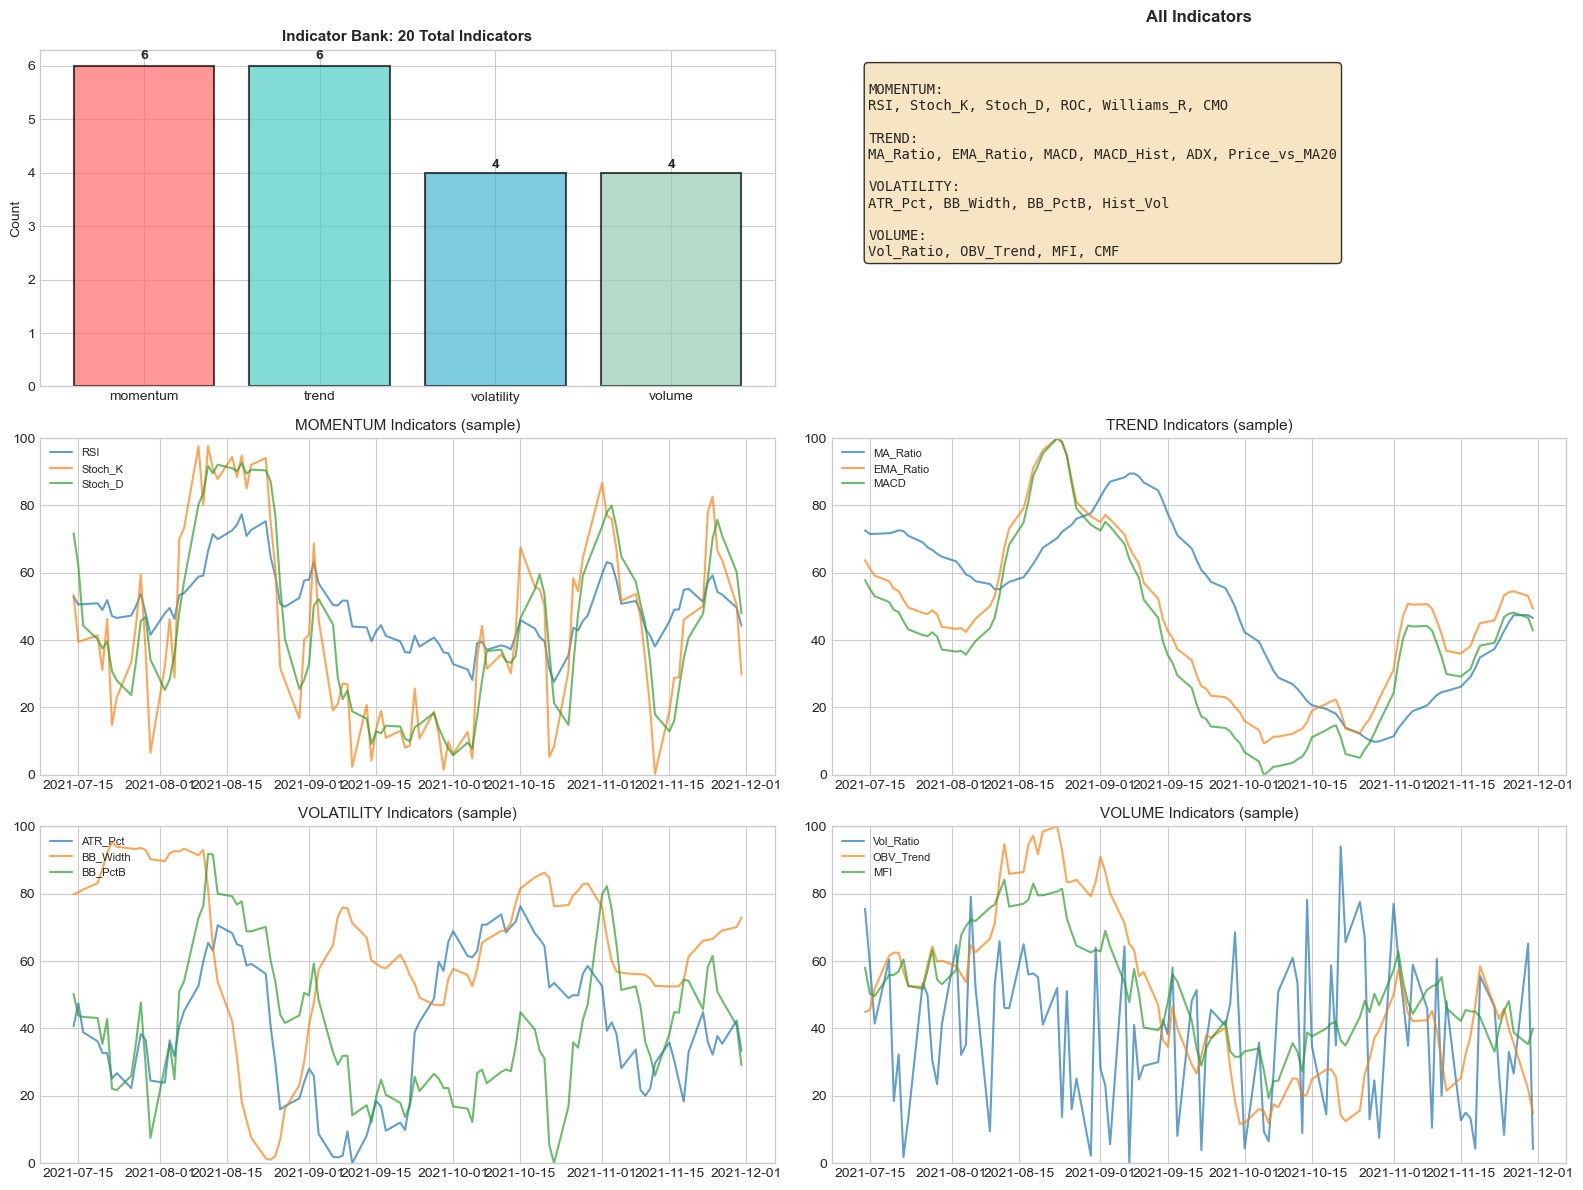


INDICATOR BANK SUMMARY

MOMENTUM (6):
  - RSI
  - Stoch_K
  - Stoch_D
  - ROC
  - Williams_R
  - CMO

TREND (6):
  - MA_Ratio
  - EMA_Ratio
  - MACD
  - MACD_Hist
  - ADX
  - Price_vs_MA20

VOLATILITY (4):
  - ATR_Pct
  - BB_Width
  - BB_PctB
  - Hist_Vol

VOLUME (4):
  - Vol_Ratio
  - OBV_Trend
  - MFI
  - CMF

STEP 2: CORRELATION ANALYSIS


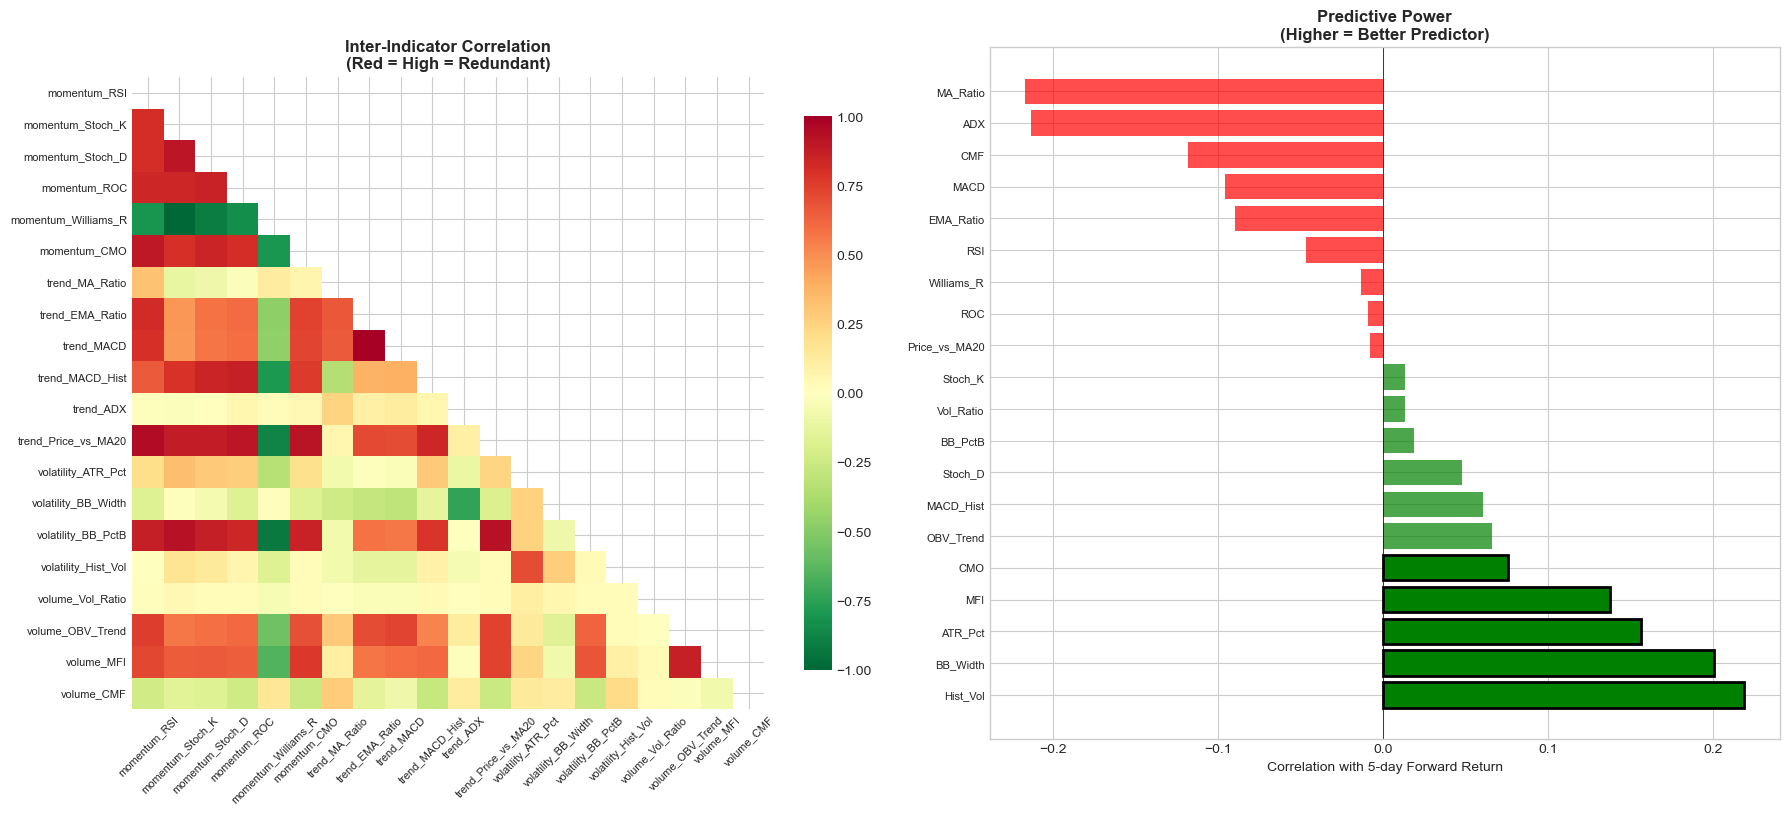


CORRELATION ANALYSIS RESULTS

TOP 5 Predictive Indicators:
  1. volatility_Hist_Vol: 0.2187
  2. volatility_BB_Width: 0.2005
  3. volatility_ATR_Pct: 0.1563
  4. volume_MFI: 0.1377
  5. momentum_CMO: 0.0758

BOTTOM 5 (contrarian signals):
  1. trend_EMA_Ratio: -0.0894
  2. trend_MACD: -0.0959
  3. volume_CMF: -0.1181
  4. trend_ADX: -0.2130
  5. trend_MA_Ratio: -0.2165

STEP 3: COMBO SELECTION


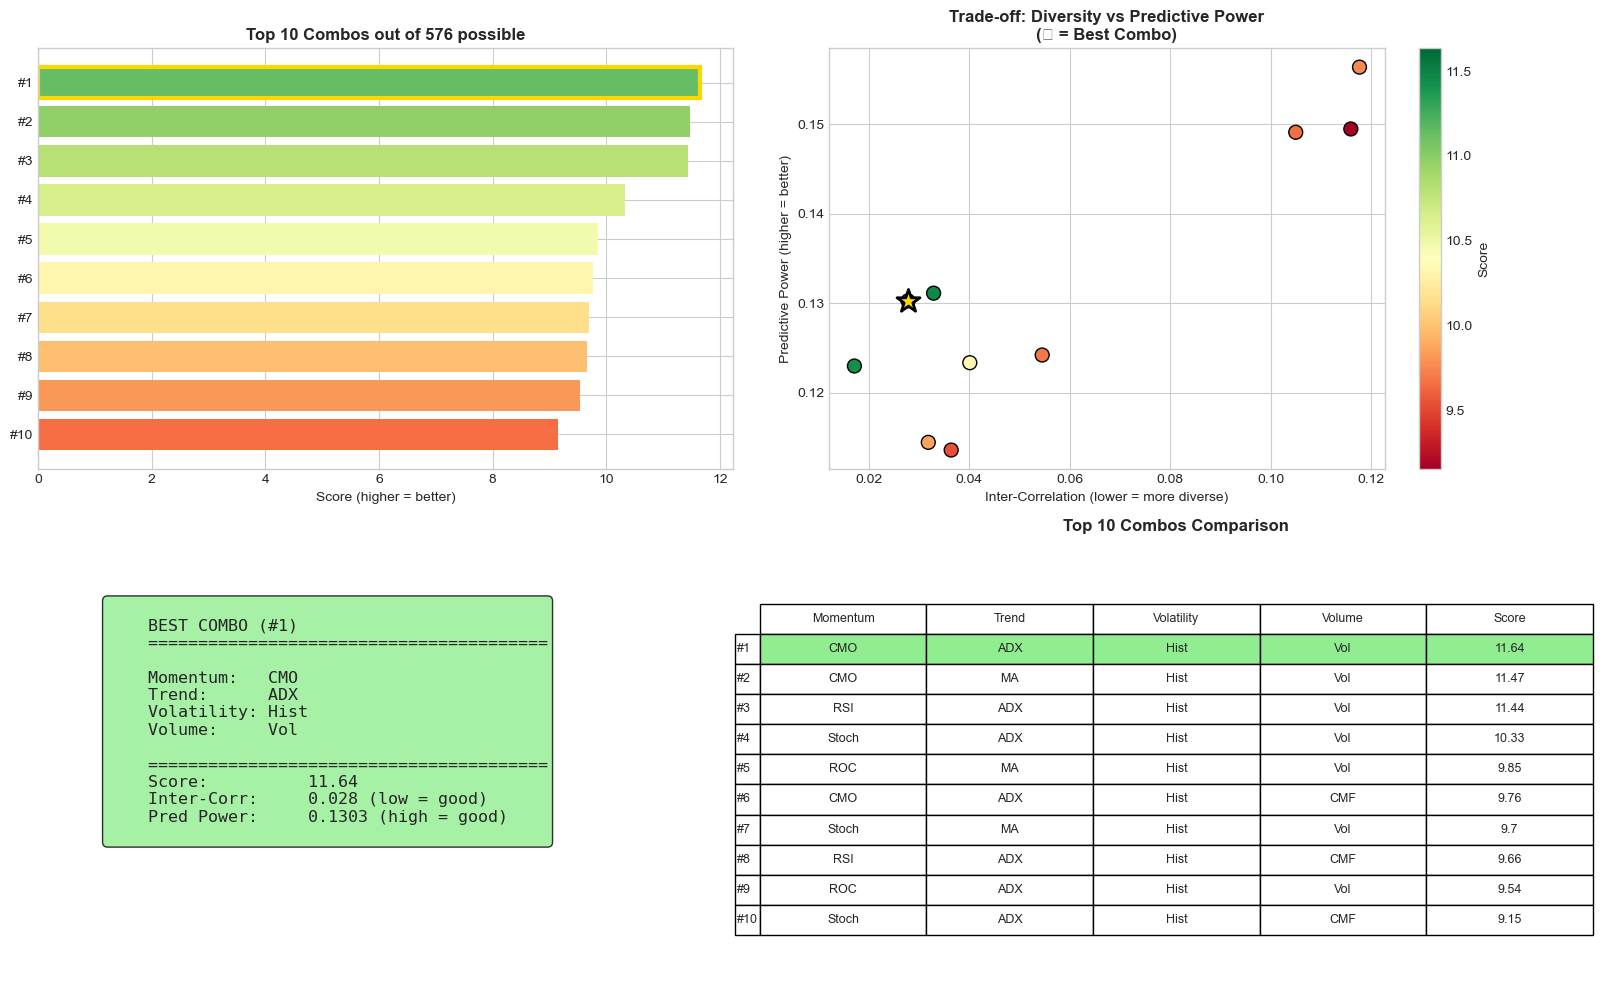


COMBO SELECTION RESULTS

Total possible combos: 576
Evaluated all 576 combinations

BEST COMBO:
  Momentum:   CMO
  Trend:      ADX
  Volatility: Hist
  Volume:     Vol

  Score: 11.64
  Inter-Correlation: 0.028
  Predictive Power: 0.1303

STEP 4: ML OPTIMIZATION
  [1/4] Optimizing weights via classification...
  [2/4] Refining weights to maximize Sharpe (BUY_BUFFER=2, SELL_BUFFER=1)...
  [3/4] Optimizing thresholds via grid search...
  [4/4] Evaluating performance across market regimes...


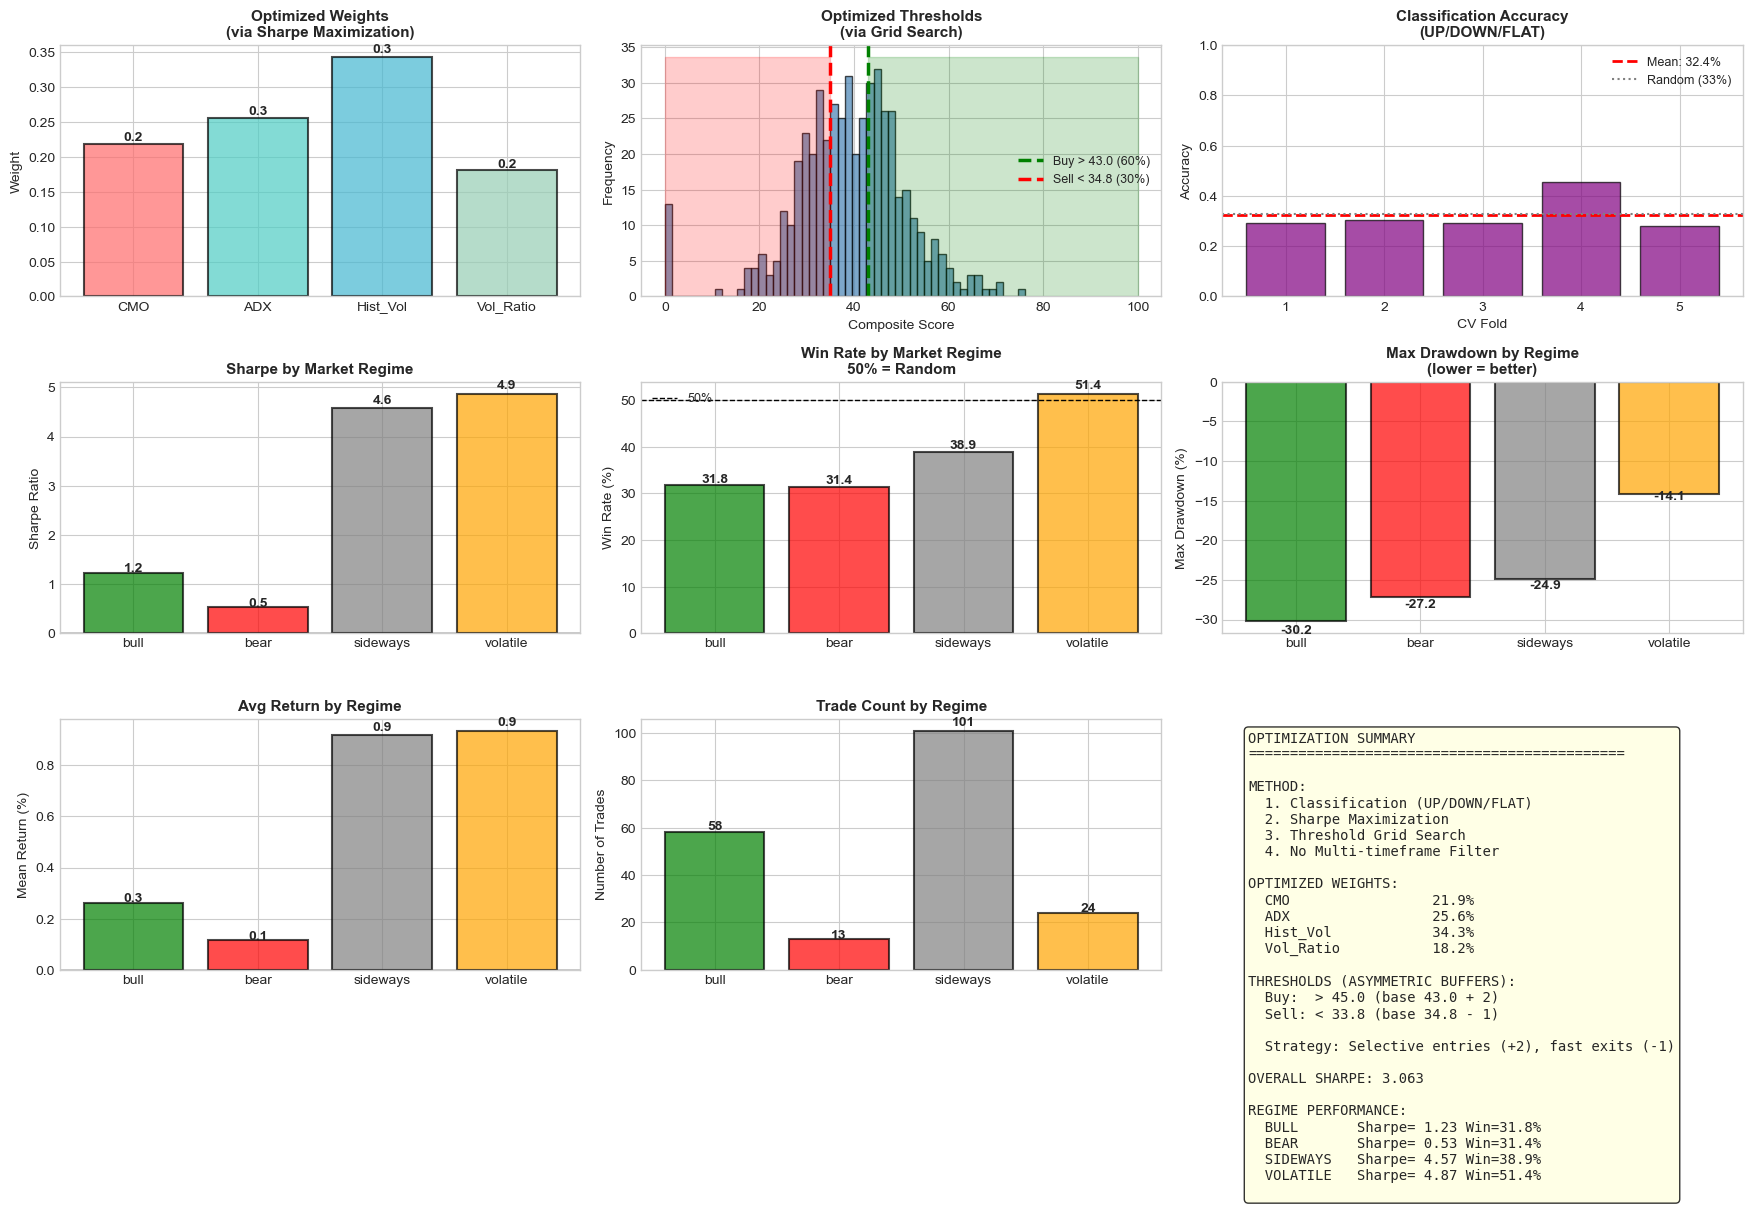


ML OPTIMIZATION RESULTS

✓ CLASSIFICATION ACCURACY:
  Mean: 32.4% (vs 33% random)
  Range: 27.8% - 45.6%

✓ OPTIMIZED WEIGHTS (Sharpe-maximizing):
  CMO                  21.91%
  ADX                  25.59%
  Hist_Vol             34.33%
  Vol_Ratio            18.16%

✓ OPTIMIZED THRESHOLDS (Grid Search + ASYMMETRIC BUFFERS):
  Buy:  > 45.0 (base 43.0 + BUY_BUFFER 2)
  Sell: < 33.8 (base 34.8 - SELL_BUFFER 1)
  Strategy: More selective on entries (+2), faster on exits (-1)

✓ PERFORMANCE BY MARKET REGIME:
  Regime         Sharpe   WinRate    AvgRet     MaxDD   Trades
  ------------------------------------------------------------
  BULL             1.23     31.8%     0.26%    -30.2%       58
  BEAR             0.53     31.4%     0.12%    -27.2%       13
  SIDEWAYS         4.57     38.9%     0.92%    -24.9%      101
  VOLATILE         4.87     51.4%     0.94%    -14.1%       24

STEP 5: FINAL INDICATOR


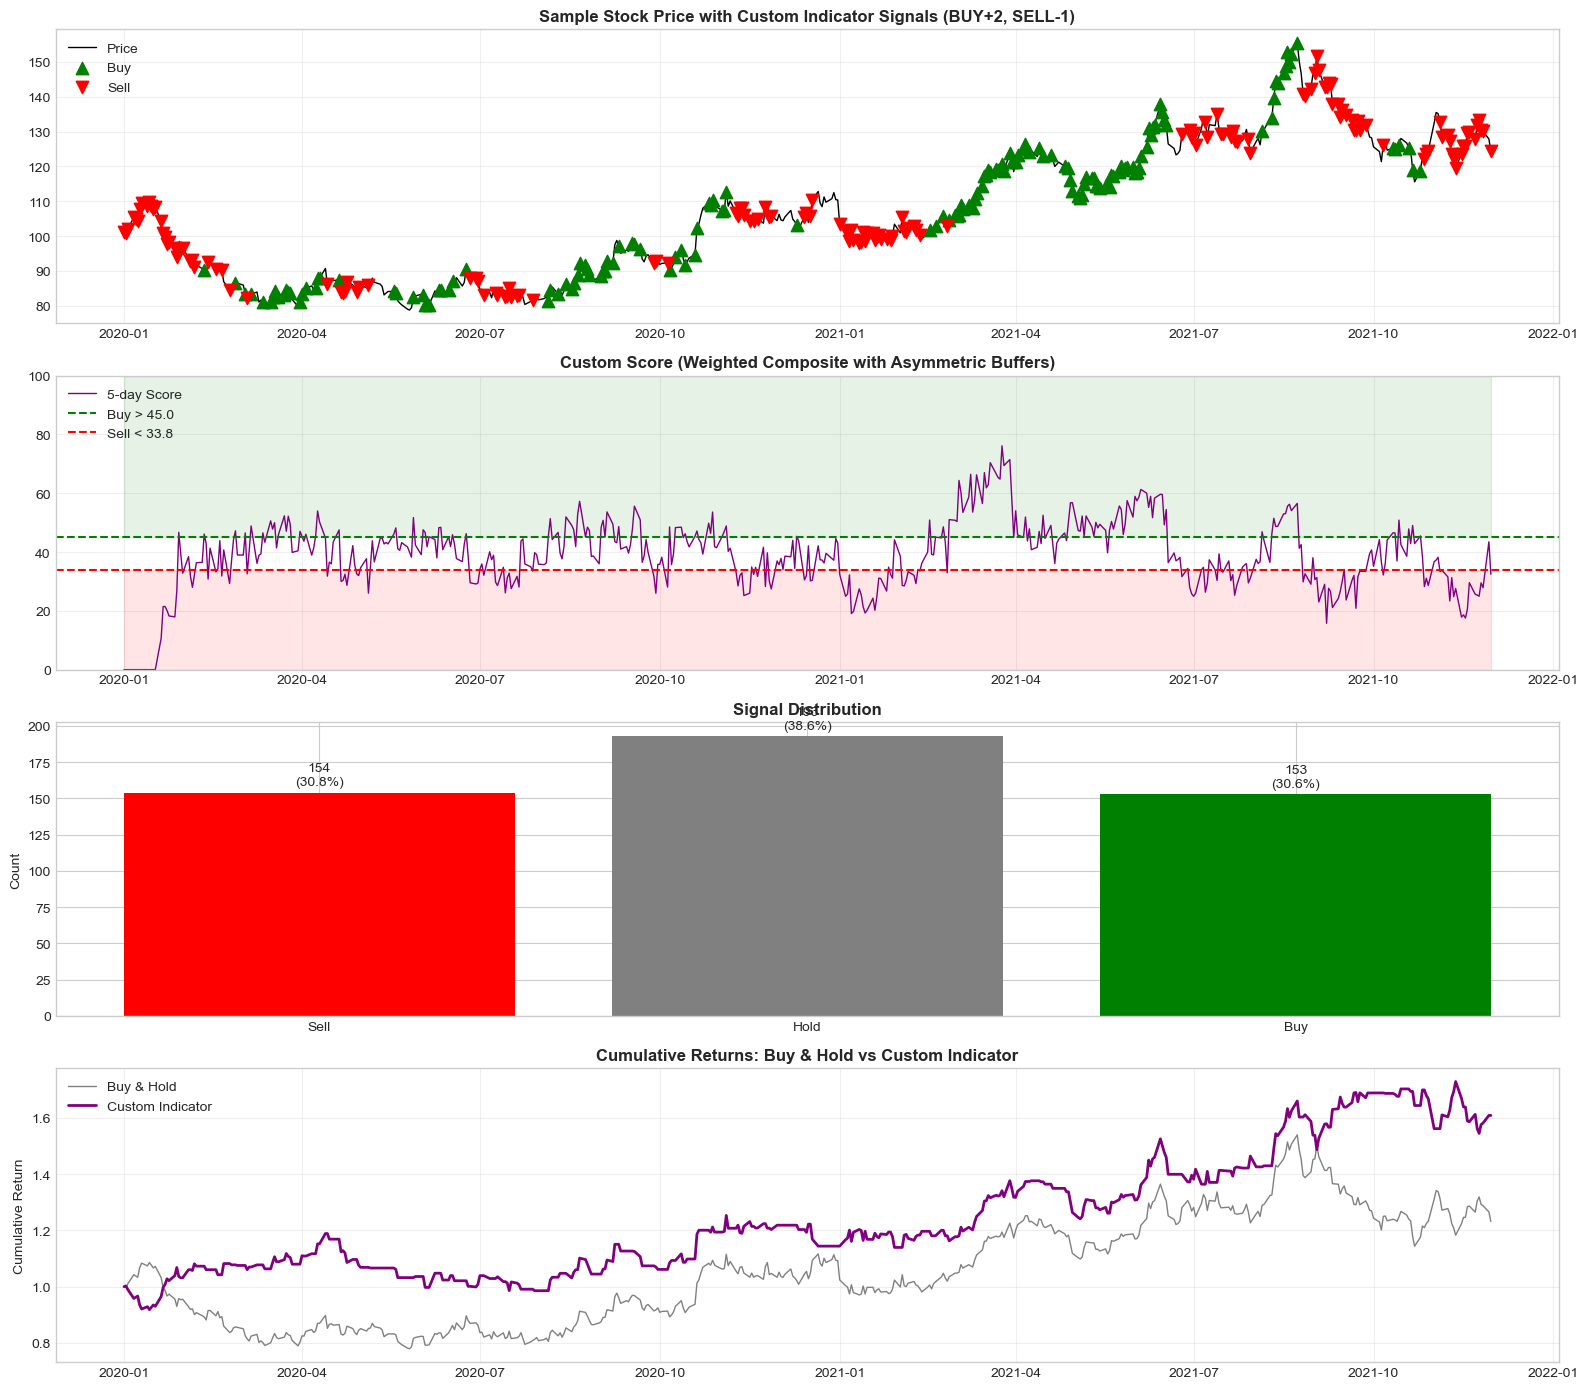


FINAL CUSTOM INDICATOR SUMMARY

COMBO: ['CMO', 'ADX', 'Hist_Vol', 'Vol_Ratio']

WEIGHTS:
  CMO                  21.91%
  ADX                  25.59%
  Hist_Vol             34.33%
  Vol_Ratio            18.16%

THRESHOLDS (ASYMMETRIC BUFFERS):
  Base Buy:  43.0 + BUY_BUFFER 2 = 45.0
  Base Sell: 34.8 - SELL_BUFFER 1 = 33.8
  Strategy: More selective entries (+2), faster exits (-1)

SIGNAL DISTRIBUTION:
  Sell    154 (30.8%)
  Hold    193 (38.6%)
  Buy     153 (30.6%)

PERFORMANCE:
  Buy & Hold Return:     23.14%
  Custom Indicator:      60.81%

ADDITIONAL METRICS:
  Win Rate:              30.0%
  Sharpe Ratio:          1.078
  Max Drawdown:          -17.09%


In [78]:
# ============================================================
# GENERATE SAMPLE DATA & RUN FULL ANALYSIS
# ============================================================

# Generate realistic sample OHLCV data
np.random.seed(42)
n_days = 500

# Simulate price with trend + noise
returns = np.random.randn(n_days) * 0.02 + 0.0003  # daily returns
price = 100 * np.exp(np.cumsum(returns))

# Create OHLCV with proper numeric types
dates = pd.date_range(START_DATE, periods=n_days, freq='B')

# Generate volume as float first, then convert (avoids overflow issues)
base_volume = np.random.randint(1000000, 10000000, n_days).astype(float)
volume_multiplier = 1 + np.abs(returns) * 10
volume = base_volume * volume_multiplier

# Generate OHLCV correctly at creation time (no post-hoc modification)
# High must be >= max(Open, Close), Low must be <= min(Open, Close)
open_prices = price * (1 + np.random.randn(n_days) * 0.005)
high_noise = np.abs(np.random.randn(n_days) * 0.015)
low_noise = np.abs(np.random.randn(n_days) * 0.015)

ohlcv = pd.DataFrame({
    'Open': open_prices,
    'High': np.maximum(np.maximum(open_prices, price), price * (1 + high_noise)),
    'Low': np.minimum(np.minimum(open_prices, price), price * (1 - low_noise)),
    'Close': price,
    'Volume': volume
}, index=dates)

# Do NOT modify OHLCV data after creation - real exchange data is already valid

print(f"Sample OHLCV data generated: {len(ohlcv)} days")
print(ohlcv.head())

# Run full analysis with all visualizations!
indicator, result = run_full_analysis(ohlcv, 'Sample Stock')